# Extended ITS Analysis

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

## Read Data

In [2]:
''' Read Data - Choose ONE of the following datasets '''

# Travel Distance per trip: LAD
# file = 'mobility indicators/daily_alltrips_duration_distance_GLAresidence_homearea_pertrip/mean_distance_lad_merge_result.csv'
# area_key = 'LAD22CD'
# use_col = 'GLA'
# output_filename = 'Travel Distance LAD'

# Travel Distance per trip: MSOA
# file = 'mobility indicators/daily_alltrips_duration_distance_GLAresidence_homearea_pertrip/mean_distance_msoa_merge_result.csv'
# area_key = 'MSOA21CD'
# use_col = 'GLA'
# output_filename = 'Travel Distance MSOA'

# Casual Activity Count: LAD
# file = 'mobility indicators/daily_count_casual_activities/merge_result_lad.csv'
# area_key = 'LAD22CD'
# use_col = 'activity_count'
# output_filename = 'Casual Activity Count LAD'

# Casual Activity Count: MSOA
# file = 'mobility indicators/daily_count_casual_activities/merge_result_msoa.csv'
# area_key = 'MSOA21CD'
# use_col = 'activity_count'
# output_filename = 'Casual Activity Count MSOA'

# Commuting Duration per capita: LAD
# file = 'mobility indicators/daily_commuting_duration_distance/mean_duration_distance_lad_merge_result.csv'
# area_key = 'LAD22CD'
# use_col = 'duration_minutes'
# output_filename = 'Commuting Duration LAD'

# Commuting Duration per capita: MSOA
file = 'mobility indicators/daily_commuting_duration_distance/mean_duration_distance_msoa_merge_result.csv'
area_key = 'MSOA21CD'
use_col = 'duration_minutes'
output_filename = 'Commuting Duration MSOA'

In [3]:
''' Read Data '''

data = pd.read_csv(file)
data.rename(columns={use_col: 'count'}, inplace=True)
folder_name = file.split('/')[1]

# Convert 'day' to datetime
data['day'] = pd.to_datetime(data['day'])

# select data before 2021-12-12, remove Christmas
data = data[data['day'] < ('2021-12-12')]
data = data.groupby(['day', area_key]).agg({'count': 'mean'}).reset_index()

# Create a binary indicator for the intervention (1 if on or after Oct 25, 2021, else 0)
intervention_date = pd.to_datetime('2021-10-25')
data['intervention'] = (data['day'] >= intervention_date).astype(int)

# Create time variables (number of hours since the start of the dataset)
data['time1'] = (data['day'] - data['day'].min()).dt.total_seconds() / (60 * 60 * 24)
data['time2'] = (data['day'] - intervention_date).dt.total_seconds() / (60 * 60 * 24)
data.loc[data['time2'] < 0, 'time2'] = 0

# Create Day of Week (dow) categorical variable
data['dow'] = data['day'].dt.dayofweek
day_of_week_dummies = pd.get_dummies(data['dow'], prefix='dow', drop_first=True).astype(int)
data = pd.concat([data, day_of_week_dummies], axis=1)
data.drop(columns=['dow'], inplace=True)

data

,day,MSOA21CD,count,intervention,time1,time2,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
0,2021-10-01,E02000001,40.731667,0,0.0,0.0,0,0,0,1,0,0
1,2021-10-01,E02000002,22.058974,0,0.0,0.0,0,0,0,1,0,0
2,2021-10-01,E02000003,41.789583,0,0.0,0.0,0,0,0,1,0,0
3,2021-10-01,E02000004,22.137121,0,0.0,0.0,0,0,0,1,0,0
4,2021-10-01,E02000005,36.255833,0,0.0,0.0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
70899,2021-12-11,E02007110,40.341667,1,71.0,47.0,0,0,0,0,1,0
70900,2021-12-11,E02007111,36.831250,1,71.0,47.0,0,0,0,0,1,0
70901,2021-12-11,E02007113,94.300000,1,71.0,47.0,0,0,0,0,1,0
70902,2021-12-11,E02007114,60.933333,1,71.0,47.0,0,0,0,0,1,0


In [4]:
# remove outliers: City of London

''' LAD '''
# data = data[data['LAD22CD'] != 'E09000001']
# data

''' MSOA '''
data = data[data['MSOA21CD'] != 'E02000001']
data

,day,MSOA21CD,count,intervention,time1,time2,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
1,2021-10-01,E02000002,22.058974,0,0.0,0.0,0,0,0,1,0,0
2,2021-10-01,E02000003,41.789583,0,0.0,0.0,0,0,0,1,0,0
3,2021-10-01,E02000004,22.137121,0,0.0,0.0,0,0,0,1,0,0
4,2021-10-01,E02000005,36.255833,0,0.0,0.0,0,0,0,1,0,0
5,2021-10-01,E02000007,31.865517,0,0.0,0.0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
70899,2021-12-11,E02007110,40.341667,1,71.0,47.0,0,0,0,0,1,0
70900,2021-12-11,E02007111,36.831250,1,71.0,47.0,0,0,0,0,1,0
70901,2021-12-11,E02007113,94.300000,1,71.0,47.0,0,0,0,0,1,0
70902,2021-12-11,E02007114,60.933333,1,71.0,47.0,0,0,0,0,1,0


In [5]:
# Read Census Data

''' LAD level '''
"""
# rden: residence density, TS0006
rden = pd.read_csv('Census Data/census2021-ts006-ltla.csv').iloc[:, 2:]
rden.columns = ['LAD22CD', 'Rden']
data = data.merge(rden, on='LAD22CD', how='left')

# age: average age, TS0007
# age = pd.read_csv('Census Data/census2021-ts007-ltla.csv')

# Sfem: Share of femal, TS0008
sfem = pd.read_csv('Census Data/census2021-ts008-ltla.csv').iloc[:, 2:]
sfem['Sfem'] = sfem['Sex: Female; measures: Value'] / sfem['Sex: All persons; measures: Value']
sfem = sfem[['geography code', 'Sfem']]
sfem.columns = ['LAD22CD', 'Sfem']
data = data.merge(sfem, on='LAD22CD', how='left')

# Hedu: Higher education, TS0067
hedu = pd.read_csv('Census Data/census2021-ts067-ltla.csv')
hedu['Hedu'] = hedu['Highest level of qualification: Level 4 qualifications and above'] / hedu['Highest level of qualification: Total: All usual residents aged 16 years and over']
hedu = hedu[['geography code', 'Hedu']]
hedu.columns = ['LAD22CD', 'Hedu']
data = data.merge(hedu, on='LAD22CD', how='left')

# Scar: Share of car ownership, TS0045
scar = pd.read_csv('Census Data/census2021-ts045-ltla.csv').iloc[:, 2:]
scar['Scar'] = (scar['Number of cars or vans: Total: All households'] - scar['Number of cars or vans: No cars or vans in household']) / scar['Number of cars or vans: Total: All households']
scar = scar[['geography code', 'Scar']]
scar.columns = ['LAD22CD', 'Scar']
data = data.merge(scar, on='LAD22CD', how='left')

# DistWork: Distance to work, TS0058
# distwork = pd.read_csv('Census Data/census2021-ts058-ltla.csv').iloc[:, 2:]

# CarWork: Share of car to work, TS0061
carwork = pd.read_csv('Census Data/census2021-ts061-ltla.csv').iloc[:, 2:]
carwork['CarWork'] = carwork['Method of travel to workplace: Driving a car or van'] / carwork['Method of travel to workplace: Total: All usual residents aged 16 years and over in employment the week before the census']
carwork = carwork[['geography code', 'CarWork']]
carwork.columns = ['LAD22CD', 'CarWork']
data = data.merge(carwork, on='LAD22CD', how='left')

# Swfh: Share of working from home, TS0061
swfh = pd.read_csv('Census Data/census2021-ts061-ltla.csv').iloc[:, 2:]
swfh['Swfh'] = swfh['Method of travel to workplace: Work mainly at or from home'] / swfh['Method of travel to workplace: Total: All usual residents aged 16 years and over in employment the week before the census']
swfh = swfh[['geography code', 'Swfh']]
swfh.columns = ['LAD22CD', 'Swfh']
data = data.merge(swfh, on='LAD22CD', how='left')

# Income: GDHI
gdhi = pd.read_csv('Census Data/income_GDHI2021_LondonLAD.csv', usecols=['mnemonic', 'GDHI per head index (UK = 100)'])
gdhi.columns = ['LAD22CD', 'Income']
data = data.merge(gdhi, on='LAD22CD', how='left')

# PTAL: Public Transport Accessibility Level
ptal = pd.read_csv('PTAL/LAD2022 AvPTAI2015.csv')
ptal.columns = ['LAD22CD', 'PTAL']
data = data.merge(ptal, on='LAD22CD', how='left')

social_vars = ['Rden', 'Sfem', 'Hedu', 'Scar', 'CarWork', 'Swfh', 'Income', 'PTAL']
"""


''' MSOA level '''
# """
# rden: residence density, TS0006
rden = pd.read_csv('Census Data/census2021-ts006-msoa.csv').iloc[:, 2:]
rden.columns = ['MSOA21CD', 'Rden']
data = data.merge(rden, on='MSOA21CD', how='left')

# age: average age, TS0007
# age = pd.read_csv('Census Data/census2021-ts007-msoa.csv')

# Sfem: Share of femal, TS0008
sfem = pd.read_csv('Census Data/census2021-ts008-msoa.csv').iloc[:, 2:]
sfem['Sfem'] = sfem['Sex: Female; measures: Value'] / sfem['Sex: All persons; measures: Value']
sfem = sfem[['geography code', 'Sfem']]
sfem.columns = ['MSOA21CD', 'Sfem']
data = data.merge(sfem, on='MSOA21CD', how='left')

# Hedu: Higher education, TS0067
hedu = pd.read_csv('Census Data/census2021-ts067-msoa.csv')
hedu['Hedu'] = hedu['Highest level of qualification: Level 4 qualifications and above'] / hedu['Highest level of qualification: Total: All usual residents aged 16 years and over']
hedu = hedu[['geography code', 'Hedu']]
hedu.columns = ['MSOA21CD', 'Hedu']
data = data.merge(hedu, on='MSOA21CD', how='left')

# Scar: Share of car ownership, TS0045
scar = pd.read_csv('Census Data/census2021-ts045-msoa.csv').iloc[:, 2:]
scar['Scar'] = (scar['Number of cars or vans: Total: All households'] - scar['Number of cars or vans: No cars or vans in household']) / scar['Number of cars or vans: Total: All households']
scar = scar[['geography code', 'Scar']]
scar.columns = ['MSOA21CD', 'Scar']
data = data.merge(scar, on='MSOA21CD', how='left')

# DistWork: Distance to work, TS0058
# distwork = pd.read_csv('Census Data/census2021-ts058-msoa.csv').iloc[:, 2:]

# CarWork: Share of car to work, TS0061
carwork = pd.read_csv('Census Data/census2021-ts061-msoa.csv').iloc[:, 2:]
carwork['CarWork'] = carwork['Method of travel to workplace: Driving a car or van'] / carwork['Method of travel to workplace: Total: All usual residents aged 16 years and over in employment the week before the census']
carwork = carwork[['geography code', 'CarWork']]
carwork.columns = ['MSOA21CD', 'CarWork']
data = data.merge(carwork, on='MSOA21CD', how='left')

# Swfh: Share of working from home, TS0061
swfh = pd.read_csv('Census Data/census2021-ts061-msoa.csv').iloc[:, 2:]
swfh['Swfh'] = swfh['Method of travel to workplace: Work mainly at or from home'] / swfh['Method of travel to workplace: Total: All usual residents aged 16 years and over in employment the week before the census']
swfh = swfh[['geography code', 'Swfh']]
swfh.columns = ['MSOA21CD', 'Swfh']
data = data.merge(swfh, on='MSOA21CD', how='left')

# PTAL: Public Transport Accessibility Level
ptal = pd.read_csv('PTAL/MSOA2021 AvPTAI2015.csv')
ptal.columns = ['MSOA21CD', 'PTAI']
data = data.merge(ptal, on='MSOA21CD', how='left')

social_vars = ['Rden', 'Sfem', 'Hedu', 'Scar', 'CarWork', 'Swfh', 'PTAI']
# """

''' centering '''
for var in social_vars:
    data[f'{var}_centered'] = data[var] - data[var].mean()

# fillna
data.fillna(0, inplace=True)

data

,day,MSOA21CD,count,intervention,time1,time2,dow_1,dow_2,dow_3,dow_4,...,CarWork,Swfh,PTAI,Rden_centered,Sfem_centered,Hedu_centered,Scar_centered,CarWork_centered,Swfh_centered,PTAI_centered
0,2021-10-01,E02000002,22.058974,0,0.0,0.0,0,0,0,1,...,0.390364,0.209389,3.731210,-5026.489665,0.011285,-0.157130,0.089183,0.177695,-0.205515,-9.741173
1,2021-10-01,E02000003,41.789583,0,0.0,0.0,0,0,0,1,...,0.320351,0.255059,7.723008,-3467.789665,-0.010004,-0.126085,0.113502,0.107682,-0.159844,-5.749375
2,2021-10-01,E02000004,22.137121,0,0.0,0.0,0,0,0,1,...,0.391779,0.250803,4.164166,-6193.889665,-0.004318,-0.158805,0.172050,0.179110,-0.164100,-9.308217
3,2021-10-01,E02000005,36.255833,0,0.0,0.0,0,0,0,1,...,0.355821,0.220485,6.134339,470.010335,-0.002920,-0.128397,0.127605,0.143151,-0.194418,-7.338044
4,2021-10-01,E02000007,31.865517,0,0.0,0.0,0,0,0,1,...,0.344803,0.186798,5.266994,-3003.089665,0.011205,-0.149199,0.033500,0.132134,-0.228105,-8.205389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70829,2021-12-11,E02007110,40.341667,1,71.0,47.0,0,0,0,0,...,0.060488,0.538293,31.598791,12055.210335,0.001859,0.097620,-0.378426,-0.152182,0.123389,18.126408
70830,2021-12-11,E02007111,36.831250,1,71.0,47.0,0,0,0,0,...,0.034812,0.629448,42.214395,345.810335,-0.020926,0.211720,-0.403430,-0.177858,0.214545,28.742012
70831,2021-12-11,E02007113,94.300000,1,71.0,47.0,0,0,0,0,...,0.065438,0.596544,15.832084,1845.410335,-0.032283,0.159439,-0.297585,-0.147232,0.181641,2.359701
70832,2021-12-11,E02007114,60.933333,1,71.0,47.0,0,0,0,0,...,0.072718,0.568014,13.968328,8541.310335,-0.019362,0.112868,-0.276058,-0.139951,0.153111,0.495945


In [6]:
# Read time series data: fuel price
# This data was excluded from final analysis due to multicollinearity.

''' Fuel price weekly data '''
weekly_data = pd.read_csv('fuel price/weekly_fuel.csv')
weekly_data['Date'] = pd.to_datetime(weekly_data['Date'], format='%m/%d/%y')

# convert to daily data
daily_data = pd.DataFrame({
    'Date': pd.date_range(start='2021-09-27', end='2021-12-11', freq='D'),
    'fuel_price': 0
})
daily_data = daily_data.merge(
    weekly_data.rename(columns={'Date': 'Weekly_Date'}),
    how='left',
    left_on='Date',
    right_on='Weekly_Date'
)
daily_data['fuel_price'] = daily_data['ULSP'].ffill()
daily_data = daily_data.drop(columns=['Weekly_Date', 'ULSP'])

data = data.merge(daily_data, left_on='day', right_on='Date', how='left')
data.drop(columns=['Date'], inplace=True)
data

,day,MSOA21CD,count,intervention,time1,time2,dow_1,dow_2,dow_3,dow_4,...,Swfh,PTAI,Rden_centered,Sfem_centered,Hedu_centered,Scar_centered,CarWork_centered,Swfh_centered,PTAI_centered,fuel_price
0,2021-10-01,E02000002,22.058974,0,0.0,0.0,0,0,0,1,...,0.209389,3.731210,-5026.489665,0.011285,-0.157130,0.089183,0.177695,-0.205515,-9.741173,135.19
1,2021-10-01,E02000003,41.789583,0,0.0,0.0,0,0,0,1,...,0.255059,7.723008,-3467.789665,-0.010004,-0.126085,0.113502,0.107682,-0.159844,-5.749375,135.19
2,2021-10-01,E02000004,22.137121,0,0.0,0.0,0,0,0,1,...,0.250803,4.164166,-6193.889665,-0.004318,-0.158805,0.172050,0.179110,-0.164100,-9.308217,135.19
3,2021-10-01,E02000005,36.255833,0,0.0,0.0,0,0,0,1,...,0.220485,6.134339,470.010335,-0.002920,-0.128397,0.127605,0.143151,-0.194418,-7.338044,135.19
4,2021-10-01,E02000007,31.865517,0,0.0,0.0,0,0,0,1,...,0.186798,5.266994,-3003.089665,0.011205,-0.149199,0.033500,0.132134,-0.228105,-8.205389,135.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70829,2021-12-11,E02007110,40.341667,1,71.0,47.0,0,0,0,0,...,0.538293,31.598791,12055.210335,0.001859,0.097620,-0.378426,-0.152182,0.123389,18.126408,146.89
70830,2021-12-11,E02007111,36.831250,1,71.0,47.0,0,0,0,0,...,0.629448,42.214395,345.810335,-0.020926,0.211720,-0.403430,-0.177858,0.214545,28.742012,146.89
70831,2021-12-11,E02007113,94.300000,1,71.0,47.0,0,0,0,0,...,0.596544,15.832084,1845.410335,-0.032283,0.159439,-0.297585,-0.147232,0.181641,2.359701,146.89
70832,2021-12-11,E02007114,60.933333,1,71.0,47.0,0,0,0,0,...,0.568014,13.968328,8541.310335,-0.019362,0.112868,-0.276058,-0.139951,0.153111,0.495945,146.89


## Level 1 model: classic ITS

In [7]:
''' level 1: classic ITS (OLS model) '''
# create formula
level1_vars = ['intervention', 'time1', 'time2'] + [f'dow_{i}' for i in range(1, 7)]
formula = 'count ~ ' + ' + '.join(level1_vars)

# fit the model
md = smf.ols(formula, data)
mdf = md.fit()
print(mdf.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     514.1
Date:                Mon, 19 May 2025   Prob (F-statistic):               0.00
Time:                        15:26:34   Log-Likelihood:            -2.7821e+05
No. Observations:               70834   AIC:                         5.564e+05
Df Residuals:                   70824   BIC:                         5.565e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       35.1395      0.191    184.139   

In [8]:
''' level 1: classic ITS (OLS model) + fuel price '''
md = smf.ols(formula + ' + fuel_price', data)
mdf = md.fit()
print(mdf.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     467.6
Date:                Mon, 19 May 2025   Prob (F-statistic):               0.00
Time:                        15:26:34   Log-Likelihood:            -2.7818e+05
No. Observations:               70834   AIC:                         5.564e+05
Df Residuals:                   70823   BIC:                         5.565e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -39.5210     10.933     -3.615   

In [9]:
''' level 1: classic ITS (Multilevel model) '''
# Multilevel Model (also known as linear mixed-effect model / multilevel linear regression)
md = smf.mixedlm(formula, data, groups=data[area_key])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: count       
No. Observations: 70834   Method:             REML        
No. Groups:       1001    Scale:              133.9318    
Min. group size:  49      Log-Likelihood:     -275126.7345
Max. group size:  72      Converged:          Yes         
Mean group size:  70.8                                    
----------------------------------------------------------
               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept      35.150    0.222 158.005 0.000 34.714 35.586
intervention    0.981    0.189   5.186 0.000  0.610  1.352
time1          -0.020    0.011  -1.782 0.075 -0.041  0.002
time2          -0.008    0.012  -0.673 0.501 -0.031  0.015
dow_1          -0.346    0.164  -2.112 0.035 -0.667 -0.025
dow_2          -0.709    0.164  -4.323 0.000 -1.030 -0.387
dow_3          -0.069    0.164  -0.418 0.676 -0.391  0.253
dow_4   

## Level 2 model: extended ITS

In [10]:
''' level 2.0: use IMD '''
# # create formula
# level1_vars = ['intervention', 'time1', 'time2'] + [f'dow_{i}' for i in range(1, 7)]
# level2_vars = ['IMD19_centered']
# formula = 'count ~ ' + ' + '.join(level1_vars) + ' + ' + ' + '.join(level2_vars)
# 
# # add interaction terms
# for var in ['intervention', 'time2']:
#     for l2_var in level2_vars:
#         formula += f' + {var}:{l2_var}'
# 
# print('Formula:', formula, '\n')
# 
# # Multilevel Model (also known as linear mixed-effect model / multilevel linear regression)
# md = smf.mixedlm(formula, data, groups=data[area_key])
# mdf = md.fit(method=["lbfgs"])
# print(mdf.summary())
# 
# # Calculate R-squared
# y_true = data['count']
# y_pred = mdf.fittedvalues
# ss_res = np.sum((y_true - y_pred)**2)
# ss_tot = np.sum((y_true - np.mean(y_true))**2)
# r_squared = 1 - (ss_res / ss_tot)
# print(f"R-squared: {r_squared:.4f}")
# 
# # Calculate ICC
# random_effects_var = mdf.cov_re.iloc[0, 0]
# residual_var = mdf.scale
# icc = random_effects_var / (random_effects_var + residual_var)
# print(f"Intraclass Correlation Coefficient (ICC): {icc:.4f}")


' level 2.0: use IMD '

In [11]:
''' level 2.1: use Census '''
# create formula
level1_vars = ['intervention', 'time1', 'time2'] + [f'dow_{i}' for i in range(1, 7)]
level2_vars = [f'{var}_centered' for var in social_vars]  #+ ['fuel_price']
formula = 'count ~ ' + ' + '.join(level1_vars) + ' + ' + ' + '.join(level2_vars)

# add interaction terms
for var in ['intervention', 'time2']:
    for l2_var in level2_vars:
        formula += f' + {var}:{l2_var}'

print('Formula:', formula, '\n')

# Multilevel Model (also known as linear mixed-effect model / multilevel linear regression)
md = smf.mixedlm(formula, data, groups=data[area_key])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

# Calculate R-squared
y_true = data['count']
y_pred = mdf.fittedvalues
ss_res = np.sum((y_true - y_pred)**2)
ss_tot = np.sum((y_true - np.mean(y_true))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f"R-squared: {r_squared:.4f}")

# Calculate ICC
random_effects_var = mdf.cov_re.iloc[0, 0]
residual_var = mdf.scale
icc = random_effects_var / (random_effects_var + residual_var)
print(f"Intraclass Correlation Coefficient (ICC): {icc:.4f}")


Formula: count ~ intervention + time1 + time2 + dow_1 + dow_2 + dow_3 + dow_4 + dow_5 + dow_6 + Rden_centered + Sfem_centered + Hedu_centered + Scar_centered + CarWork_centered + Swfh_centered + PTAI_centered + intervention:Rden_centered + intervention:Sfem_centered + intervention:Hedu_centered + intervention:Scar_centered + intervention:CarWork_centered + intervention:Swfh_centered + intervention:PTAI_centered + time2:Rden_centered + time2:Sfem_centered + time2:Hedu_centered + time2:Scar_centered + time2:CarWork_centered + time2:Swfh_centered + time2:PTAI_centered 



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


                   Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       count       
No. Observations:       70834         Method:                   REML        
No. Groups:             1001          Scale:                    133.8685    
Min. group size:        49            Log-Likelihood:           -275049.1355
Max. group size:        72            Converged:                Yes         
Mean group size:        70.8                                                
----------------------------------------------------------------------------
                               Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
----------------------------------------------------------------------------
Intercept                      35.137    0.215 163.103 0.000  34.714  35.559
intervention                    0.981    0.189   5.187 0.000   0.610   1.352
time1                          -0.020    0.011  -1.784 0.074  -0.041   0.002
time2              

In [12]:
# mark significance
def add_stars(p_value):
    if p_value < 0.001:
        return "***"
    elif p_value < 0.01:
        return "**"
    elif p_value < 0.05:
        return "*"
    elif p_value < 0.1:
        return "."
    else:
        return ""

results_df = pd.DataFrame({
    'coef': mdf.params,
    'P>|z|': mdf.pvalues,
    '[0.025': mdf.conf_int()[0],
    '0.975]': mdf.conf_int()[1]
})

results_df['sig'] = results_df['P>|z|'].apply(add_stars)  # significance
results_df['coef'] = results_df['coef'].apply(lambda x: f"{x:.3f}") #+ results_df['sig']
results_df['P>|z|'] = results_df['P>|z|'].apply(lambda x: f"{x:.3f}")
results_df['[0.025'] = results_df['[0.025'].apply(lambda x: f"{x:.3f}"[:6])
results_df['0.975]'] = results_df['0.975]'].apply(lambda x: f"{x:.3f}"[:6])

results_df = results_df[[ 'coef','sig', 'P>|z|', '[0.025', '0.975]']]
results_df.to_csv('results/'+ output_filename + '.csv')
results_df

,coef,sig,P>|z|,[0.025,0.975]
Intercept,35.137,***,0.000,34.714,35.559
intervention,0.981,***,0.000,0.610,1.352
time1,-0.020,.,0.074,-0.041,0.002
time2,-0.008,,0.501,-0.031,0.015
dow_1,-0.346,*,0.035,-0.667,-0.025
dow_2,-0.709,***,0.000,-1.030,-0.387
dow_3,-0.069,,0.676,-0.390,0.253
dow_4,-1.561,***,0.000,-1.875,-1.246
dow_5,-6.610,***,0.000,-6.928,-6.292
dow_6,-7.995,***,0.000,-8.323,-7.666


## Prepare for mapping - calculate abrupt and gradual effects

In [13]:
# Calculate abrupt effect in each MSOA
effect_df = data[['MSOA21CD']+social_vars].drop_duplicates()
effect_df['abrupt_effect'] = mdf.params['intervention']
for var in social_vars:
    effect_df['abrupt_effect'] += mdf.params[f'intervention:{var}_centered'] * effect_df[var]

# Calculate gradual effect in each MSOA
effect_df['gradual_effect'] = mdf.params['time2']
for var in social_vars:
    effect_df['gradual_effect'] += mdf.params[f'time2:{var}_centered'] * effect_df[var]

effect_df

,MSOA21CD,Rden,Sfem,Hedu,Scar,CarWork,Swfh,PTAI,abrupt_effect,gradual_effect
0,E02000002,3831.0,0.526748,0.309106,0.681533,0.390364,0.209389,3.731210,4.946136,-0.349426
1,E02000003,5389.7,0.505458,0.340151,0.705852,0.320351,0.255059,7.723008,5.522002,-0.347576
2,E02000004,2663.6,0.511145,0.307432,0.764400,0.391779,0.250803,4.164166,5.341715,-0.346443
3,E02000005,9327.5,0.512543,0.337840,0.719956,0.355821,0.220485,6.134339,5.457761,-0.350715
4,E02000007,5854.4,0.526668,0.317037,0.625850,0.344803,0.186798,5.266994,5.042455,-0.350965
...,...,...,...,...,...,...,...,...,...,...
996,E02007113,10702.9,0.483179,0.625675,0.294766,0.065438,0.596544,15.832084,3.882977,-0.315730
997,E02007114,17398.8,0.496100,0.579105,0.316293,0.072718,0.568014,13.968328,4.467122,-0.319422
998,E02007115,17336.9,0.522782,0.435147,0.209219,0.064570,0.457033,67.752144,3.454265,-0.300045
1318,E02000354,12111.2,0.528151,0.508932,0.375783,0.107266,0.464683,20.702088,4.828084,-0.342045


In [14]:
# Link with geo data
map_data = gpd.read_file('UK Geo Data/Middle_layer_Super_Output_Areas_December_2021_Boundaries_EW_BGC_V3.geojson')
map_data = map_data.merge(effect_df, on='MSOA21CD', how='left')
map_data.to_file('results/' + output_filename + '.geojson', driver='GeoJSON')
map_data

,FID,MSOA21CD,MSOA21NM,MSOA21NMW,BNG_E,BNG_N,LAT,LONG,GlobalID,geometry,Rden,Sfem,Hedu,Scar,CarWork,Swfh,PTAI,abrupt_effect,gradual_effect
0,1,E02000001,City of London 001,,532384,181355,51.51562,-0.093490,71249043-b176-4306-ba6c-d1a993b1b741,"POLYGON ((532135.138 182198.131, 532158.250 18...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,E02000002,Barking and Dagenham 001,,548267,189685,51.58652,0.138756,997a80a8-0ebe-461c-91eb-3e4122571a6e,"POLYGON ((548881.563 190845.265, 548881.125 19...",3831.0,0.526748,0.309106,0.681533,0.390364,0.209389,3.731210,4.946136,-0.349426
2,3,E02000003,Barking and Dagenham 002,,548259,188520,51.57606,0.138149,62ded9d9-f53a-454d-af35-04404d9dbe9b,"POLYGON ((549102.438 189324.625, 548954.517 18...",5389.7,0.505458,0.340151,0.705852,0.320351,0.255059,7.723008,5.522002,-0.347576
3,4,E02000004,Barking and Dagenham 003,,551004,186412,51.55639,0.176828,511181cd-e71f-4c63-81ee-e8e76744a627,"POLYGON ((551550.056 187364.705, 551478.000 18...",2663.6,0.511145,0.307432,0.764400,0.391779,0.250803,4.164166,5.341715,-0.346443
4,5,E02000005,Barking and Dagenham 004,,548733,186824,51.56069,0.144267,b0c823eb-69e0-4ae7-9e1c-37715cf3fe87,"POLYGON ((549099.634 187656.076, 549161.375 18...",9327.5,0.512543,0.337840,0.719956,0.355821,0.220485,6.134339,5.457761,-0.350715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7259,7260,W02000424,Wrexham 021,Wrecsam 021,335589,355197,53.09010,-2.963220,d42ac770-ac81-4883-b475-dad3fb302924,"POLYGON ((332638.500 357396.594, 332706.480 35...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7260,7261,W02000425,Wrexham 022,Wrecsam 022,337505,353566,53.07567,-2.934290,728d3024-3caa-4bc6-84a8-6a0118a516d8,"POLYGON ((335857.094 359909.500, 335987.000 35...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7261,7262,W02000426,Wrexham 023,Wrecsam 023,334766,351723,53.05877,-2.974800,777609dd-352d-4f22-81f6-3fde80d4a17d,"POLYGON ((333857.695 350484.982, 333617.312 35...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7262,7263,W02000427,Neath Port Talbot 021,Castell-nedd Port Talbot 021,287336,198958,51.67806,-3.630870,f8192bda-7e6b-4dba-9eaa-b2c6320eb547,"POLYGON ((281673.596 204539.202, 282167.187 20...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


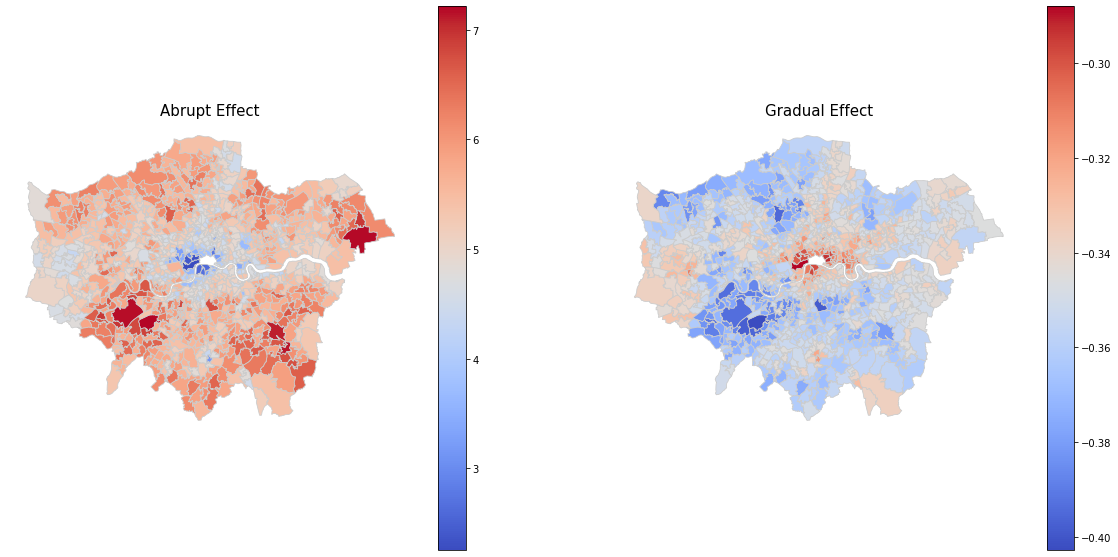

In [15]:
# Plot map
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Abrupt effect
map_data.plot(column='abrupt_effect', cmap='coolwarm', linewidth=0.8, ax=ax[0], edgecolor='0.8', legend=True)
ax[0].set_title(f'Abrupt Effect', fontsize=15)
ax[0].axis('off')

# Gradual effect
map_data.plot(column='gradual_effect', cmap='coolwarm', linewidth=0.8, ax=ax[1], edgecolor='0.8', legend=True)
ax[1].set_title(f'Gradual Effect', fontsize=15)
ax[1].axis('off')

plt.show()

## Plot Maps

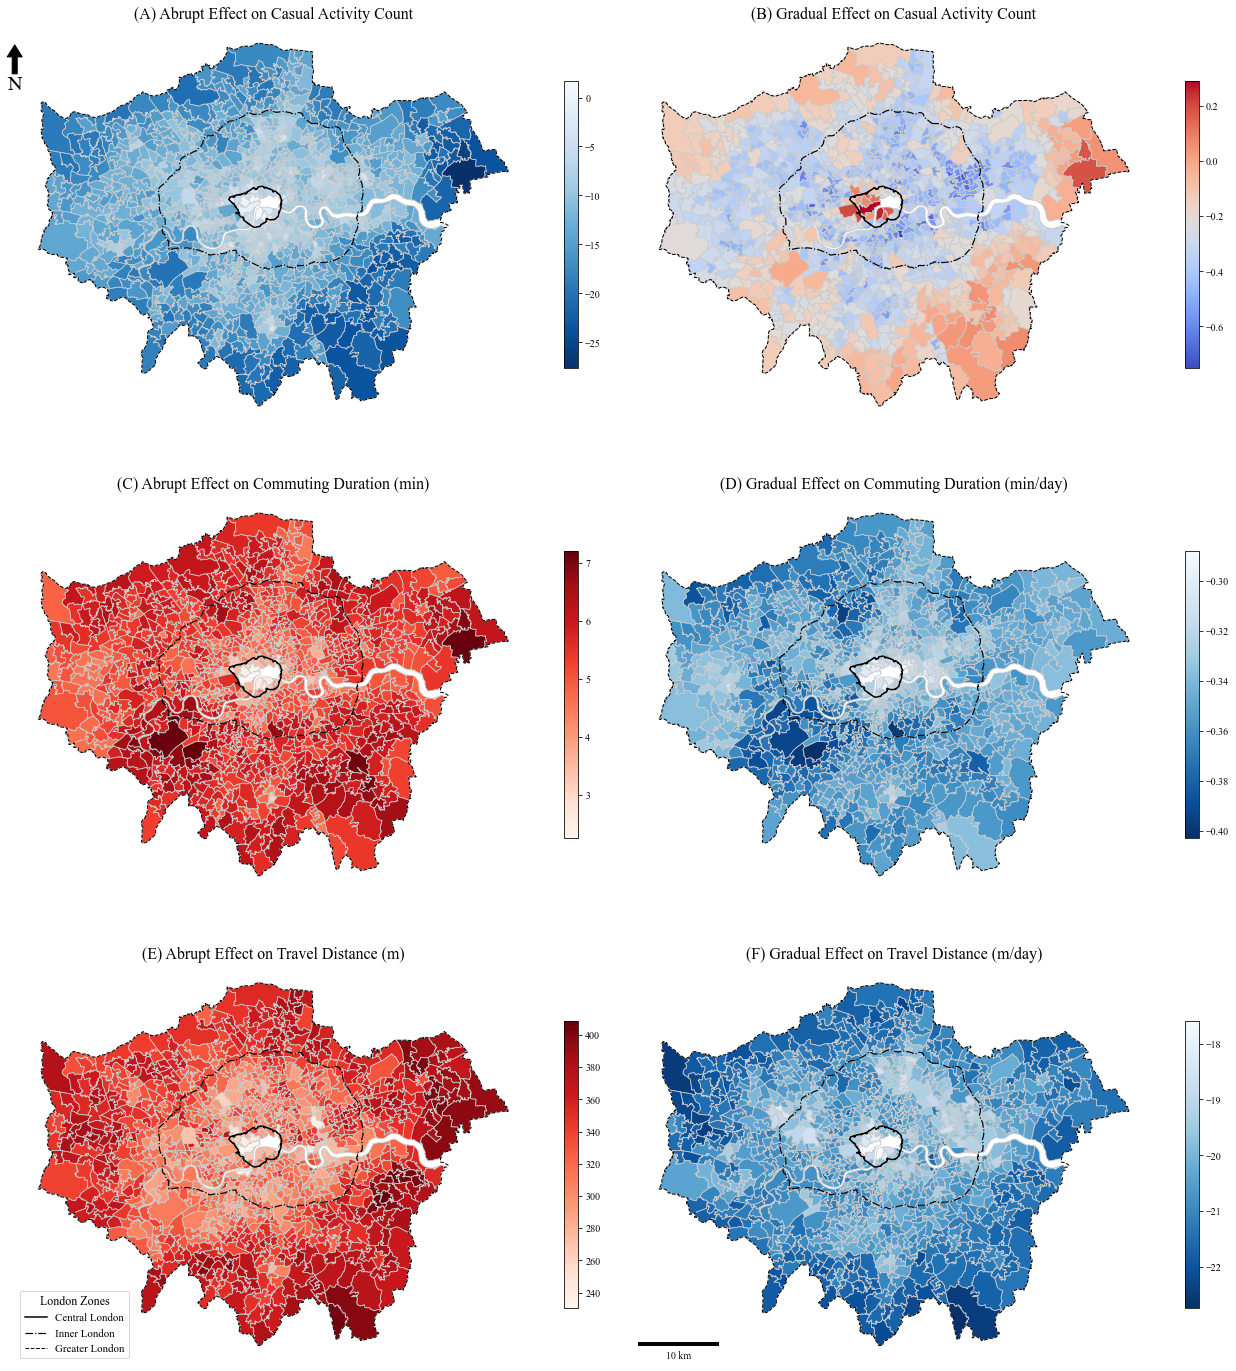

In [16]:
# Plot six maps
import matplotlib as mpl
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.lines import Line2D

# Use Times New Roman everywhere
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman']

# read data
data1 = gpd.read_file('results/Casual Activity Count MSOA.geojson')
data2 = gpd.read_file('results/Commuting Duration MSOA.geojson')
data3 = gpd.read_file('results/Travel Distance MSOA.geojson')

CentralLondon = gpd.read_file('UK Geo Data/CentralLondon_boundary.geojson').to_crs('epsg:27700')
InnerLondon = gpd.read_file('UK Geo Data/InnerLondon_boundary.geojson').to_crs('epsg:27700')
GLA = gpd.read_file("UK Geo Data/GLA_boundary.geojson").to_crs('epsg:27700')

# plot
fig, axes = plt.subplots(3, 2, figsize=(18, 20))
legend_kwds={'shrink': 0.6}  # Shrink and position legend  #'anchor': (0, 0)

# Casual Activity Count
data1.plot(column='abrupt_effect', cmap='Blues_r', linewidth=0.8, ax=axes[0, 0], edgecolor='0.8', legend=True, legend_kwds=legend_kwds)
axes[0, 0].set_title(f'(A) Abrupt Effect on Casual Activity Count', fontsize=16)
data1.plot(column='gradual_effect', cmap='coolwarm', linewidth=0.8, ax=axes[0, 1], edgecolor='0.8', legend=True, legend_kwds=legend_kwds)
axes[0, 1].set_title(f'(B) Gradual Effect on Casual Activity Count', fontsize=16)

# Commuting Duration
data2.plot(column='abrupt_effect', cmap='Reds', linewidth=0.8, ax=axes[1, 0], edgecolor='0.8', legend=True, legend_kwds=legend_kwds)
axes[1, 0].set_title(f'(C) Abrupt Effect on Commuting Duration (min)', fontsize=16)
data2.plot(column='gradual_effect', cmap='Blues_r', linewidth=0.8, ax=axes[1, 1], edgecolor='0.8', legend=True, legend_kwds=legend_kwds)
axes[1, 1].set_title(f'(D) Gradual Effect on Commuting Duration (min/day)', fontsize=16)

# Travel Distance
data3.plot(column='abrupt_effect', cmap='Reds', linewidth=0.8, ax=axes[2, 0], edgecolor='0.8', legend=True, legend_kwds=legend_kwds)
axes[2, 0].set_title(f'(E) Abrupt Effect on Travel Distance (m)', fontsize=16)
data3.plot(column='gradual_effect', cmap='Blues_r', linewidth=0.8, ax=axes[2, 1], edgecolor='0.8', legend=True, legend_kwds=legend_kwds)
axes[2, 1].set_title(f'(F) Gradual Effect on Travel Distance (m/day)', fontsize=16)

# add London boundaries
for ax in axes.flatten():
    ax.axis('off')
    # overlay zone boundaries with distinct styles
    GLA.boundary.plot(ax=ax, edgecolor='black', linewidth=1.0, linestyle='--')
    InnerLondon.boundary.plot(ax=ax, edgecolor='black', linewidth=1.2, linestyle='-.')
    CentralLondon.boundary.plot(ax=ax, edgecolor='black', linewidth=1.5, linestyle='-')

proxies = [
    Line2D([0], [0], color='black', lw=1.5, ls='-'),
    Line2D([0], [0], color='black', lw=1.2, ls='-.'),
    Line2D([0], [0], color='black', lw=1.0, ls='--'),
]
axes[2, 0].legend(
    proxies,
    ['Central London', 'Inner London', 'Greater London'],
    loc='lower left',
    fontsize=11,
    frameon=True,
    title='London Zones',
    title_fontsize=12,
)

# Add Compass
x, y, arrow_length = 0, 0.95, 0.1
axes[0, 0].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=axes[0, 0].transAxes)

# Add scale bar
scale = ScaleBar(
    dx=1,
    location="lower left",  # in relation to the whole plot
    scale_loc="bottom",  # in relation to the line
)

axes[2, 1].add_artist(scale)

plt.tight_layout()
plt.show()
fig.savefig('results/Figure3.jpg', dpi=300, bbox_inches='tight')